# Bayesian inference with JAGS in Python

In this notebook, the Bayesian inference engine JAGS is run from the command-line using Python. The `Jags` class writes the model and data to a file and generates a script for JAGS to run. The chains created by JAGS are parsed and plots generated to show the samples and histograms of the variables of interest. 

The `Jags` class requires a temporary folder to be specified in which to write the files. While debugging a model, it might be useful to inspect the model, data or script. If there is an error running JAGS, the standard output and standard error are printed.

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import subprocess

In [2]:
class Jags:
    """JAGS-Python interface."""
    
    model_filename = "temp.bug"
    data_filename = "data.R"
    script_filename = "script.jags"
    temp_directory_prefix = "python-jags-"
    
    def __init__(self, root_temp_folder, jags_executable):
        
        # Preconditions
        assert os.path.exists(root_temp_folder), f"Temporary folder doesn't exist: {root_temp_folder}"
        assert os.path.exists(jags_executable), f"JAGS executable doesn't exist: {jags_executable}"
        
        self.temp_root_folder = root_temp_folder  # Location for the folder of i/o files for JAGS
        self.jags_executable = jags_executable    # Location of the JAGS binary
        
        self.temp_folder = None
    
    @staticmethod
    def _write_to_file(filepath, s):
        """Write a string to a file."""
        
        # Preconditions
        assert isinstance(filepath, str), f"Expected a str, got {type(filepath)}"
        assert isinstance(s, str), f"Expected a str, got {type(s)}"        
        
        with open(filepath, 'w') as fp:
            fp.write(s)        
    
    def _build_script(self,
                      model_filepath, 
                      data_filepath=None, 
                      n_chains=2, 
                      burnin=10000, 
                      params_to_monitor=[], 
                      update=10000):
        """Build the JAGS script that is used by the executable."""
        
        # Preconditions
        assert isinstance(model_filepath, str), f"Expected a str, got {type(model_filepath)}"
        assert os.path.exists(model_filepath), f"Model file doesn't exist: {model_filepath}"
        assert data_filepath is None or os.path.exists(data_filepath)
        assert isinstance(n_chains, int) and n_chains > 0
        assert isinstance(burnin, int) and burnin > 0
        assert isinstance(params_to_monitor, list)
        assert isinstance(update, int) and update > 0

        script = f"model in \"{model_filepath}\""  # Read the model file

        if data_filepath is not None:
            script += f"\ndata in \"{data_filepath}\""  # Read data from file

        script += f"\ncompile, nchains({n_chains})"  # Compile the model
        script += "\ninitialize"  # Initialise the model
        script += f"\nupdate {burnin}"  # Adaption and burnin

        for p in params_to_monitor:
            script += f"\nmonitor {p}"  # Set trace for the required node

        script += f"\nupdate {update}"  # Update for the required number of iterations
        script += f"\ncoda *\n"  # All monitored values are written to file

        return script
    
    def _write_script_to_file(self, script):
        """Write the JAGS script to a file."""
        
        assert isinstance(script, str), f"Expected a str, got {type(script)}"
        
        script_filepath = os.path.join(self.temp_folder, Jags.script_filename)
        self._write_to_file(script_filepath, script)
        
        return script_filepath
    
    def _write_model_to_file(self, model):
        """Write the JAGS model to a file."""
        
        assert isinstance(model, str), f"Expected a str, got {type(model)}"
        
        model_filepath = os.path.join(self.temp_folder, Jags.model_filename)
        self._write_to_file(model_filepath, model)
    
        return model_filepath
    
    def _write_data_to_file(self, data):
        """Write the data to be used by JAGS to a file."""
        
        # Preconditions
        assert isinstance(data, str), f"Expected a str, got {type(data)}"
        
        data_filepath = os.path.join(self.temp_folder, Jags.data_filename)
        self._write_to_file(data_filepath, data)
    
        return data_filepath        
        
    def _run_jags(self, script_filepath):
        """Run JAGS."""
        
        p = subprocess.Popen([self.jags_executable, script_filepath], 
                             cwd=self.temp_folder,
                             stdout = subprocess.PIPE, stderr=subprocess.STDOUT)
    
        stdout, stderr = p.communicate()
        
        if stdout is not None:
            stdout = stdout.decode('utf-8')
        
        if stderr is not None:
            stderr = stderr.decode('utf-8')
        
        return {
            "returncode": p.returncode,
            "stdout": stdout,
            "stderr": stderr,
        }
    
    @staticmethod
    def _parse_coda_index(s):
        """Parse the coda index (read from file)."""

        # Preconditions
        assert isinstance(s, list), f"Expected a str, got {type(s)}"

        # Dict of variable name to (start, end) tuple
        d = {}

        for line in s:
            parts = line.strip().split(" ")
            assert len(parts) == 3, f"Expected 3 parts, got {len(parts)}"

            lower, upper = (int(parts[1])-1, int(parts[2])-1)
            assert lower <= upper

            d[parts[0]] = (lower, upper)

        return d
    
    @staticmethod
    def _parse_coda_index_file(filepath):
        """Parse the coda index file."""

        # Preconditions
        assert os.path.exists(filepath), f"Coda file doesn't exist: {filepath}"

        with open(filepath, 'r') as fp:
            content = fp.readlines()

        return Jags._parse_coda_index(content)
    
    def _read_coda_index(self):
        """Read the CODA index."""
        
        filepath = os.path.join(self.temp_folder, "CODAindex.txt")
        assert os.path.exists(filepath), f"Unable to find CODA index: {filepath}"
        
        return Jags._parse_coda_index_file(filepath)
    
    @staticmethod
    def _index_to_variable_name(coda_index, index):
        """Returns the variable name for a given index."""

        # Preconditions
        assert isinstance(coda_index, dict), f"Expected a dict, got {type(coda_index)}"
        assert len(coda_index) > 0
        assert isinstance(index, int), f"Expected an int, got {type(index)}"
        assert index >= 0

        for name, rge in coda_index.items():
            if rge[0] <= index <= rge[1]:
                return name

        return None
    
    @staticmethod
    def _parse_chain(s, coda_index):
        """Parse the chain data."""

        # Preconditions
        assert isinstance(s, list)
        assert isinstance(coda_index, dict)

        # Dict of variable to samples
        name_to_samples = {name:[] for name in coda_index.keys()}

        index = 0
        for row in s:
            parts = row.split("  ")
            assert len(parts) == 2
            value = float(parts[1])

            name = Jags._index_to_variable_name(coda_index, int(index))
            assert name is not None
            name_to_samples[name].append(value)

            index += 1

        # Postconditions
        assert isinstance(name_to_samples, dict)
        sample_lengths = [len(samples) for samples in name_to_samples.values()]
        assert all([s-sample_lengths[0]==0 for s in sample_lengths])

        return name_to_samples    
    
    @staticmethod
    def _parse_chain_file(filepath, coda_index):
        """Parse the chain data in a file."""

        # Preconditions
        assert os.path.exists(filepath), f"Chain file doesn't exist: {filepath}"
        assert isinstance(coda_index, dict), f"Expected a dict, got {type(coda_index)}"

        with open(filepath, 'r') as fp:
            lines = fp.readlines()

        return Jags._parse_chain(lines, coda_index)    
    
    @staticmethod
    def _parse_chain_files(filepaths, coda_index):
        """Parse the chain files."""

        assert isinstance(filepaths, list)
        assert all([os.path.exists(f) for f in filepaths])
        assert isinstance(coda_index, dict)

        # The data from all of the chains is stored as a dict of
        # name: list of a list of samples
        all_chains = None

        for f in filepaths:
            
            parsed_chains = Jags._parse_chain_file(f, coda_index)
            assert isinstance(parsed_chains, dict)
            
            if all_chains is None:
                # Initialise the dict
                all_chains = {name: [] for name in parsed_chains.keys()}
            else:
                # Check all of the expected variables are present
                assert all([name in all_chains for name in parsed_chains.keys()])
                
            for name, samples in parsed_chains.items():
                all_chains[name].append(samples)

        # Postconditions
        assert isinstance(all_chains, dict)

        return all_chains
    
    def _extract_chains(self):
        """Extract the output data from JAGS."""
        
        # Read the CODA index
        coda_index = self._read_coda_index()
        
        # Get the paths to the chain data generated by JAGS
        coda_filepaths = glob.glob(self.temp_folder + "/CODAchain*.txt")
        
        return Jags._parse_chain_files(coda_filepaths, coda_index)
        
    @staticmethod
    def _make_temporary_folder(root_folder):
        """Make a temporary folder and return the path to it."""
        
        # Preconditions
        assert os.path.exists(root_folder), f"Root folder doesn't exist: {root_folder}"
        
        folder_created = False
        folder_id = 0
        
        while not folder_created:
            path = os.path.join(root_folder, Jags.temp_directory_prefix + str(folder_id))
            
            if not os.path.exists(path):
                os.mkdir(path)
                folder_created = True
            else:
                folder_id += 1
            
        return path
        
    @staticmethod
    def _delete_temporary_folder(folder):
        """Delete the temporary folder."""
        
        assert os.path.exists(folder), f"Folder doesn't exist: {folder}"
        
        try:
            shutil.rmtree(folder)
        except OSError as e:
            print(f"Failed to delete {folder} due to {e}")
    
        
    def run(self, model, data, n_chains, burnin, params_to_monitor, update):
        """Run JAGS."""
        
        # Preconditions
        assert isinstance(model, str), f"Expected a str, got {type(model)}"
        assert len(model) > 0, f"Model is empty"
        assert data is None or isinstance(data, str), f"Expected None or a str, got {type(data)}"
        
        
        # Make a temporary folder in which to write the script, model and data
        self.temp_folder = Jags._make_temporary_folder(self.temp_root_folder)
        
        # Write the model and data to files
        model_filepath = self._write_model_to_file(model)
        
        data_filepath = None
        if data is not None:
            data_filepath = self._write_data_to_file(data) 
        
        # Build the script and write to file
        script = self._build_script(model_filepath=model_filepath, 
                                    data_filepath=data_filepath, 
                                    n_chains=n_chains, 
                                    burnin=burnin, 
                                    params_to_monitor=params_to_monitor, 
                                    update=update)
        
        script_filepath = self._write_script_to_file(script)
        
        # Run JAGS
        status = self._run_jags(script_filepath)
        
        # Check whether JAGS ran successfully
        if status["returncode"] != 0:
            print(status["stdout"])
            print(status["stderr"])
            print(f"The temporary folder hasn't been cleared down: {temp_folder}")
            return None
        
        # Extract the chains
        chains = self._extract_chains()
        
        # Clear down the temporary folder
        Jags._delete_temporary_folder(self.temp_folder)
        
        # Return the chains
        return chains

In [3]:
# Temporary folder for writing to file
temp_folder = r"C:\Users\cdcla\Downloads"

# Location of the JAGS executable
jags_executable = r"C:\Program Files\JAGS\JAGS-4.3.0\x64\bin\jags.bat"

In [4]:
jags = Jags(temp_folder, jags_executable)

In [5]:
# Define the JAGS model
model = """
model {
    # Cloudy
    cloudy ~ dbinom(0.8, 1)

    # Sprinkler
    cpt_sprinkler[1] = 0.5  # Cloudy = false
    cpt_sprinkler[2] = 0.1  # Cloudy = true
    sprinkler ~ dbinom(cpt_sprinkler[cloudy + 1], 1)
    
    # Rain
    cpt_rain[1] = 0.1  # Cloudy = false
    cpt_rain[2] = 0.8  # Cloudy = true
    rain ~ dbinom(cpt_rain[cloudy + 1], 1)

    # Wet grass
    cpt_wet_grass[1,1] = 0.0   # Sprinkler = false, rain = false
    cpt_wet_grass[1,2] = 0.9   # Sprinkler = false, rain = true
    cpt_wet_grass[2,1] = 0.9   # Sprinkler = true, rain = false
    cpt_wet_grass[2,2] = 0.99  # Sprinkler = true, rain = true
    wet_grass ~ dbinom(cpt_wet_grass[sprinkler+1, rain+1], 1)
}
"""

# JAGS data
data = """
wet_grass <- 1
"""

params_to_monitor = ["cloudy", "sprinkler", "rain", "wet_grass"]

n_chains = 2
burnin = 20000
update = 10000

In [6]:
parameter_chains = jags.run(model, data, n_chains, burnin, params_to_monitor, update)

In [7]:
def plot_chains(parameter_chains):
    """Plot the parameters in the chains."""
    
    # Preconditions
    assert isinstance(parameter_chains, dict), f"Expected a dict, got {type(parameter_chains)}"
    
    fig = plt.figure(figsize=(10,20))
    axs = fig.subplots(len(parameter_chains), 2)

    for idx, name in enumerate(parameter_chains.keys()):

        # Plot the samples
        for c in parameter_chains[name]:
            axs[idx][0].plot(c)
            axs[idx][0].set_title('Trace')
            
        # Concatenate all of the samples
        all_samples = []
        for c in parameter_chains[name]:
            all_samples.extend(c)

        # Plot a histogram of the samples
        axs[idx][1].hist(all_samples, density=True, bins=50)
        axs[idx][1].set_title(f"{name} (mean = {np.mean(all_samples)})")

    plt.show()

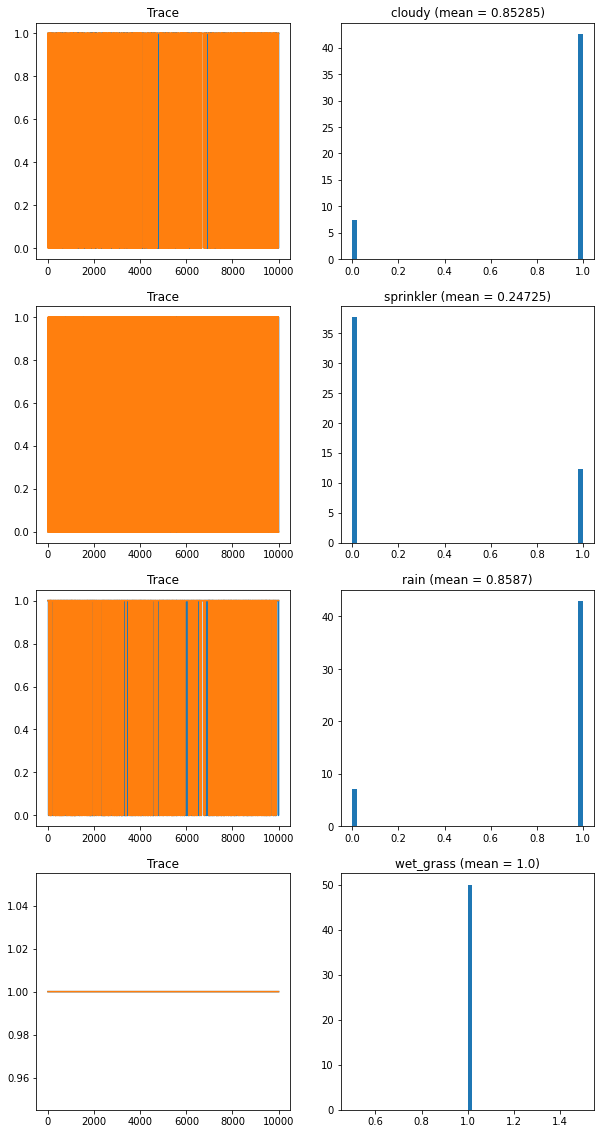

In [8]:
plot_chains(parameter_chains)